In [1]:
# Import libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models import LdaModel
from gensim import similarities

import re
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from cleantext import clean

from wordcloud import WordCloud
import seaborn as sns

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [2]:
#Import data files
ds = pd.read_csv("../data/DataScientist.csv",encoding='utf-8')
#ds = ds.head(100)

ba = pd.read_csv("../data/BusinessAnalyst.csv",encoding='utf-8')
#ba = ba.head(100)

cv_data = pd.read_csv('../data/UpdatedResumeDataSet.csv' ,encoding='utf-8')

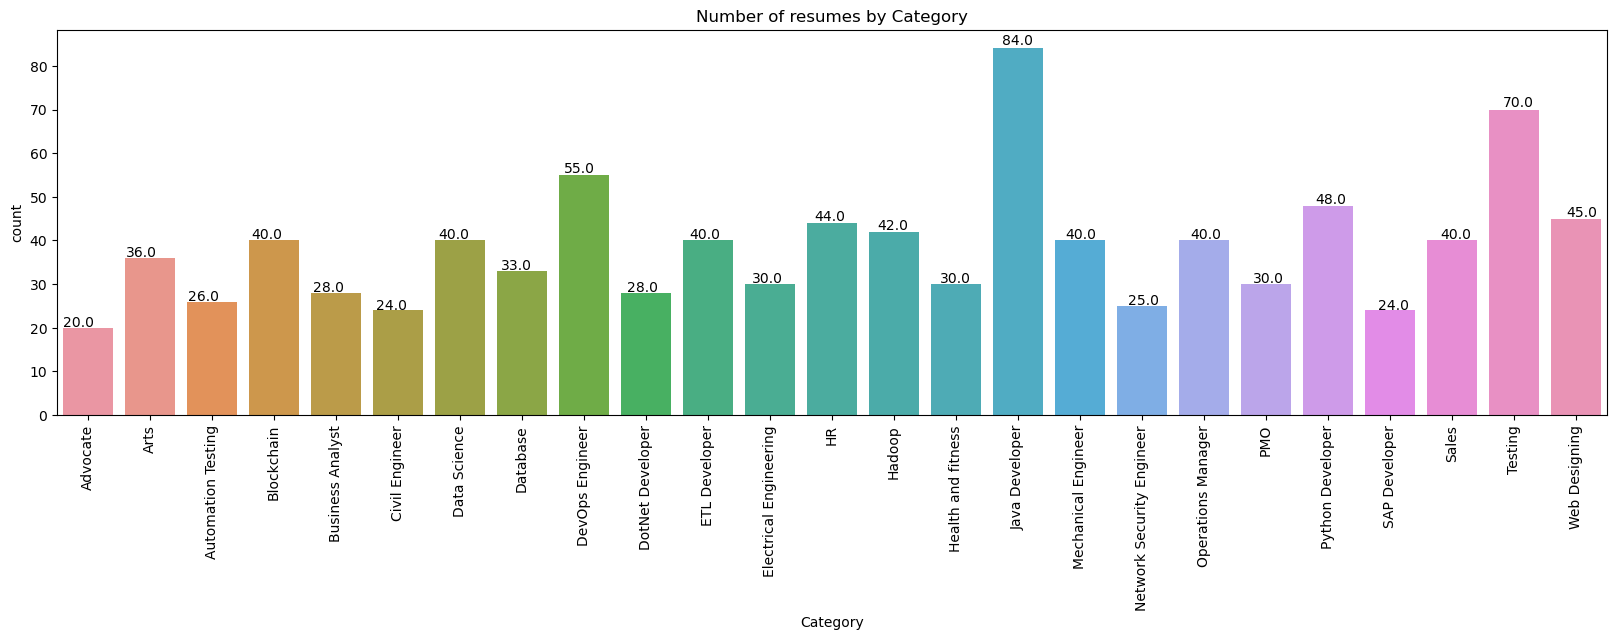

In [3]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
ax=sns.countplot(x="Category", data=cv_data.sort_values('Category'))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.title("Number of resumes by Category")
plt.show()

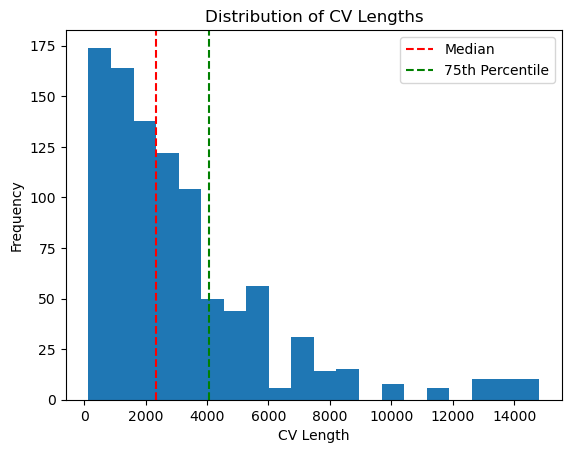

In [4]:
cv_data['cv_length'] = cv_data['Resume'].str.len()
plt.hist(cv_data['cv_length'], bins=20)
plt.xlabel('CV Length')
plt.ylabel('Frequency')
plt.title('Distribution of CV Lengths')

median_length = cv_data['cv_length'].median()
percentile_75 = cv_data['cv_length'].quantile(0.75)
plt.axvline(median_length, color='r', linestyle='--', label='Median')
plt.axvline(percentile_75, color='g', linestyle='--', label='75th Percentile')

# Display the legend
plt.legend()

# Show the plot
plt.show()

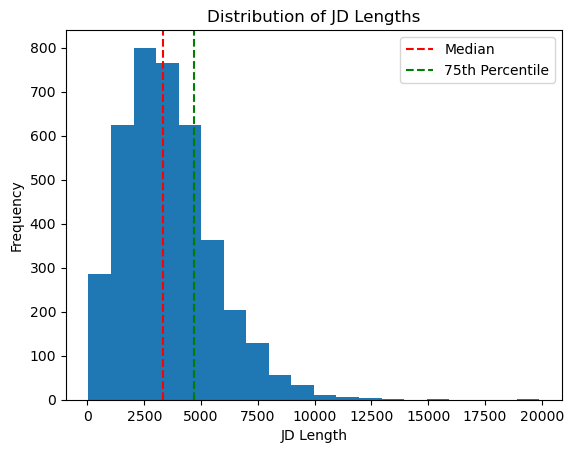

In [5]:
ds['jd_length'] = ds['Job Description'].str.len()
plt.hist(ds['jd_length'], bins=20)
plt.xlabel('JD Length')
plt.ylabel('Frequency')
plt.title('Distribution of JD Lengths')

median_length = ds['jd_length'].median()
percentile_75 = ds['jd_length'].quantile(0.75)
plt.axvline(median_length, color='r', linestyle='--', label='Median')
plt.axvline(percentile_75, color='g', linestyle='--', label='75th Percentile')

# Display the legend
plt.legend()

# Show the plot
plt.show()

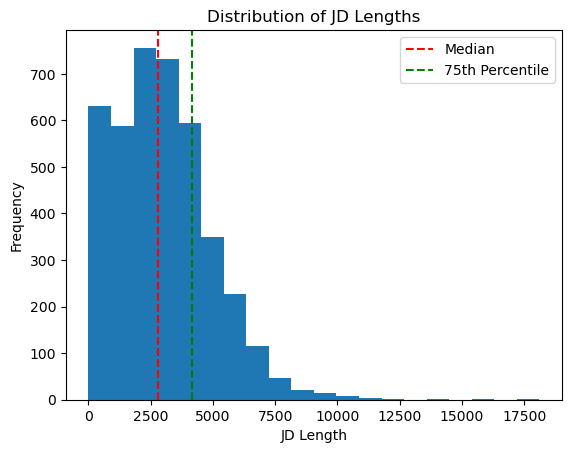

In [6]:
ba['jd_length'] = ba['Job Description'].str.len()
plt.hist(ba['jd_length'], bins=20)
plt.xlabel('JD Length')
plt.ylabel('Frequency')
plt.title('Distribution of JD Lengths')

median_length = ba['jd_length'].median()
percentile_75 = ba['jd_length'].quantile(0.75)
plt.axvline(median_length, color='r', linestyle='--', label='Median')
plt.axvline(percentile_75, color='g', linestyle='--', label='75th Percentile')

# Display the legend
plt.legend()

# Show the plot
plt.show()

### Preprocessing of data

In [7]:
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    resumeText = re.sub('\n', ' ', resumeText)
    return resumeText
    

In [8]:
cv_data['resume'] = cv_data.Resume.apply(lambda x: cleanResume(x))
cv_data.drop(columns=['Resume','cv_length'], inplace = True)
cv_data = cv_data.rename(columns = {'Category':'category'})
cv_data.head()

,category,resume
0,Data Science,Skills Programming Languages Python pandas num...
1,Data Science,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,Areas of Interest Deep Learning Control System...
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...


In [9]:
ba['description'] = ba['Job Description'].apply(lambda x: cleanResume(x))
jd_ba = ba['description']
jd_ba.head()

0    Company Overview At Memorial Sloan Kettering M...
1    We are seeking for an energetic and collaborat...
2    For more than a decade Asembia has been workin...
3    Job Description Summary The Information Securi...
4    Magnite is the world s largest independent sel...
Name: description, dtype: object

In [10]:
ds['description'] = ds['Job Description'].apply(lambda x: cleanResume(x))
jd_ds = ds['description']
jd_ds.head()

0    ABOUT HOPPER At Hopper we re on a mission to m...
1    At Noom we use scientifically proven methods t...
2    Decode M Data Science Manager Job Description ...
3    Sapphire Digital seeks a dynamic and driven mi...
4    Director Data Science 200537 Description Edelm...
Name: description, dtype: object

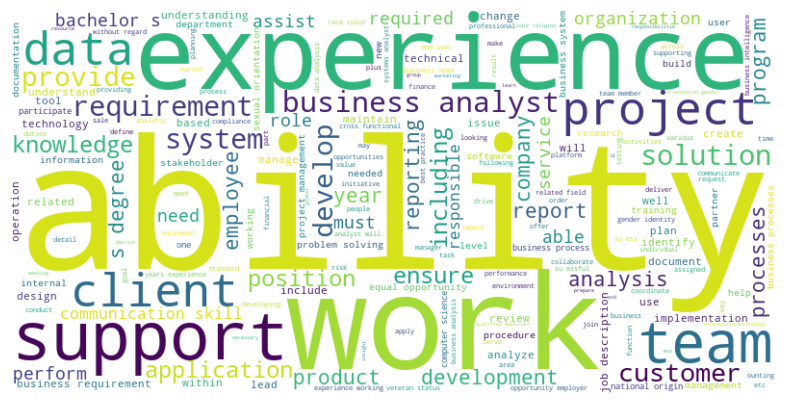

In [11]:
# Combine all texts into a single string
ba_text = ' '.join(jd_ba.values)

# Convert the text to lowercase
ba_text = ba_text.lower()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ba_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

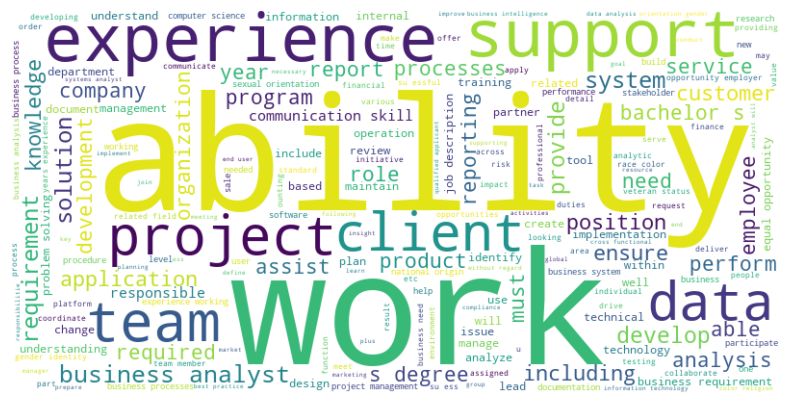

In [12]:
# Combine all texts into a single string
ds_text = ' '.join(jd_ba.values)

# Convert the text to lowercase
ds_text = ba_text.lower()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ds_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

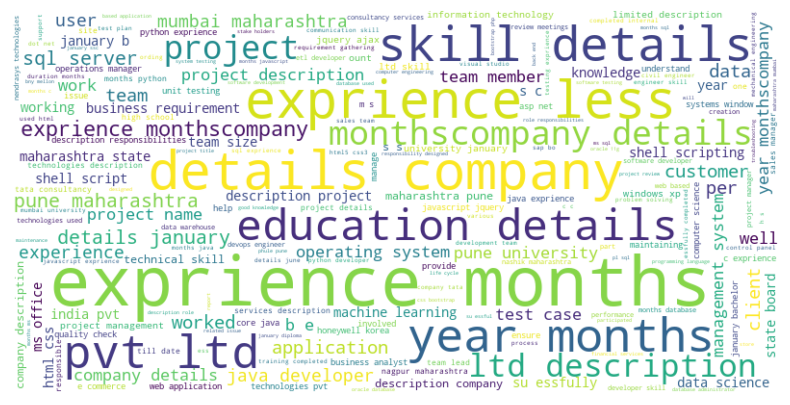

In [13]:
# Combine all resume texts into a single string
cv_text = ' '.join(cv_data['resume'].values)

# Convert the text to lowercase
cv_text = cv_text.lower()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cv_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



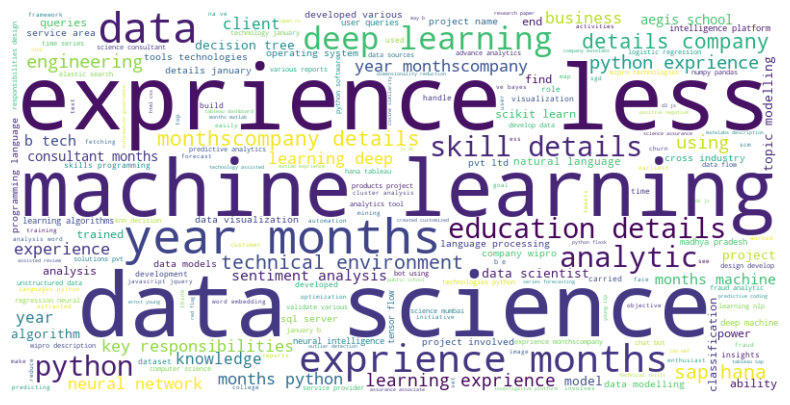

In [20]:
cv_ds = cv_data[cv_data['category'] == 'Data Science']

# Combine all resume texts into a single string
cv_ds_text = ' '.join(cv_ds['resume'].values)

# Convert the text to lowercase
cv_ds_text = cv_ds_text.lower()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cv_ds_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


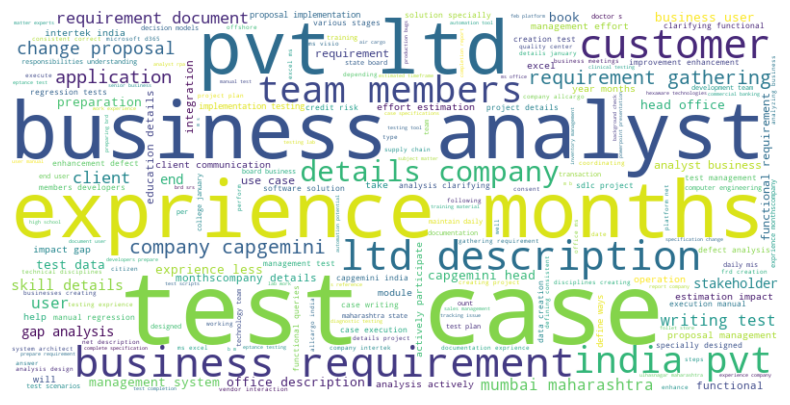

In [15]:
cv_ba = cv_data[cv_data['category'] == 'Business Analyst']

# Combine all resume texts into a single string
cv_ba_text = ' '.join(cv_ba['resume'].values)

# Convert the text to lowercase
cv_ba_text = cv_ba_text.lower()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cv_ba_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [16]:
cv_data.to_csv("../data/cv_data.csv", index=False)
jd_ds.to_csv("../data/jd_ds.csv", index=False)
jd_ba.to_csv("../data/jd_ba.csv", index=False)

In [17]:
jd_ds.info()

<class 'pandas.core.series.Series'>
RangeIndex: 3909 entries, 0 to 3908
Series name: description
Non-Null Count  Dtype 
--------------  ----- 
3909 non-null   object
dtypes: object(1)
memory usage: 30.7+ KB


In [18]:
jd_ba.info()

<class 'pandas.core.series.Series'>
RangeIndex: 4092 entries, 0 to 4091
Series name: description
Non-Null Count  Dtype 
--------------  ----- 
4092 non-null   object
dtypes: object(1)
memory usage: 32.1+ KB
